NMF vs LDA Analysis with American Presidents' Inauguration Speeches 

In [ ]:
!python -m pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# All Imports
import pandas as pd
import numpy as np
import re,string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter
import matplotlib.pyplot as plt 
import resource
import tracemalloc


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


STEP 1 : Downloading data and importing it into a Dataframe.

Data Downloaded From - https://www.kaggle.com/datasets/adhok93/presidentialaddress

In [ ]:
raw_data_df = pd.read_csv('/content/drive/MyDrive/inaug_speeches.csv', encoding='cp1252')
pd.set_option('display.max_colwidth', 150)
raw_data_df.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and of the House of Representatives: AMONG the vicissitudes incident to life no event could have fille...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again called upon by the voice of my country to execute the functions of its Chief Magistrate. When the occas...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in early times, that no middle course for America remained between unlimited submission to a foreign le..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801","Friends and Fellow-Citizens: CALLED upon to undertake the duties of the first executive office of our country, I avail myself of th..."
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to that qualification which the Constitution requires before my entrance on the charge again conferred ..."


Step 3 : Preprocessing and cleaning data

In [ ]:
raw_data_df=raw_data_df[['Name',"text"]]
raw_data_df = raw_data_df.set_index('Name')
raw_data_df.head()

,text
Name,
George Washington,Fellow-Citizens of the Senate and of the House of Representatives: AMONG the vicissitudes incident to life no event could have fille...
George Washington,Fellow Citizens: I AM again called upon by the voice of my country to execute the functions of its Chief Magistrate. When the occas...
John Adams,"WHEN it was first perceived, in early times, that no middle course for America remained between unlimited submission to a foreign le..."
Thomas Jefferson,"Friends and Fellow-Citizens: CALLED upon to undertake the duties of the first executive office of our country, I avail myself of th..."
Thomas Jefferson,"PROCEEDING, fellow-citizens, to that qualification which the Constitution requires before my entrance on the charge again conferred ..."


Data Cleaning - 

In [ ]:

def clean_raw_data(text):
    '''Removing lowercase, remove text in square brackets, 
    punctuation, remove read errors,
    and words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    
    return text
round1 = lambda x: clean_raw_data(x)
# Clean Speech Text
raw_data_df["text"] = raw_data_df["text"].apply(round1)
# Visually Inspect
raw_data_df.head()

,text
Name,
George Washington,fellow citizens of the senate and of the house of representatives among the vicissitudes incident to life no event could have fille...
George Washington,fellow citizens i am again called upon by the voice of my country to execute the functions of its chief magistrate when the occas...
John Adams,when it was first perceived in early times that no middle course for america remained between unlimited submission to a foreign le...
Thomas Jefferson,friends and fellow citizens called upon to undertake the duties of the first executive office of our country i avail myself of th...
Thomas Jefferson,proceeding fellow citizens to that qualification which the constitution requires before my entrance on the charge again conferred ...


In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:

def tokenize_words(txt):
  tokenized = word_tokenize(txt)
  return tokenized

def remove_stopwords(tokenized_txt):
  cleaned_text_array = [word for word in tokenized_txt if word not in stop_words]
  return cleaned_text_array

def word_lemmatizer(tokenized_text_without_stopwords):
  wordnet_lemmatizer = WordNetLemmatizer()
  lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in tokenized_text_without_stopwords]
  return ' '.join(lemmatized)

raw_data_df['tokenized_text']=raw_data_df['text'].apply(tokenize_words)

raw_data_df['tokenized_text_without_stopwords'] = raw_data_df['tokenized_text'].apply(lambda x: remove_stopwords(x))

raw_data_df['lemmatized_tok_txt_wo_stopwords'] = raw_data_df['tokenized_text_without_stopwords'].apply(lambda x: word_lemmatizer(x))

raw_data_df.head()

,text,tokenized_text,tokenized_text_without_stopwords,lemmatized_tok_txt_wo_stopwords
Name,,,,
George Washington,fellow citizens of the senate and of the house of representatives among the vicissitudes incident to life no event could have fille...,"[fellow, citizens, of, the, senate, and, of, the, house, of, representatives, among, the, vicissitudes, incident, to, life, no, event, could, have...","[fellow, citizens, senate, house, representatives, among, vicissitudes, incident, life, event, could, filled, greater, anxieties, notification, tr...",fellow citizen senate house representative among vicissitude incident life event could filled greater anxiety notification transmitted order recei...
George Washington,fellow citizens i am again called upon by the voice of my country to execute the functions of its chief magistrate when the occas...,"[fellow, citizens, i, am, again, called, upon, by, the, voice, of, my, country, to, execute, the, functions, of, its, chief, magistrate, when, the...","[fellow, citizens, called, upon, voice, country, execute, functions, chief, magistrate, occasion, proper, shall, arrive, shall, endeavor, express,...",fellow citizen called upon voice country execute function chief magistrate occasion proper shall arrive shall endeavor express high sense entertai...
John Adams,when it was first perceived in early times that no middle course for america remained between unlimited submission to a foreign le...,"[when, it, was, first, perceived, in, early, times, that, no, middle, course, for, america, remained, between, unlimited, submission, to, a, forei...","[first, perceived, early, times, middle, course, america, remained, unlimited, submission, foreign, legislature, total, independence, claims, men,...",first perceived early time middle course america remained unlimited submission foreign legislature total independence claim men reflection le appr...
Thomas Jefferson,friends and fellow citizens called upon to undertake the duties of the first executive office of our country i avail myself of th...,"[friends, and, fellow, citizens, called, upon, to, undertake, the, duties, of, the, first, executive, office, of, our, country, i, avail, myself, ...","[friends, fellow, citizens, called, upon, undertake, duties, first, executive, office, country, avail, presence, portion, fellow, citizens, assemb...",friend fellow citizen called upon undertake duty first executive office country avail presence portion fellow citizen assembled express grateful t...
Thomas Jefferson,proceeding fellow citizens to that qualification which the constitution requires before my entrance on the charge again conferred ...,"[proceeding, fellow, citizens, to, that, qualification, which, the, constitution, requires, before, my, entrance, on, the, charge, again, conferre...","[proceeding, fellow, citizens, qualification, constitution, requires, entrance, charge, conferred, duty, express, deep, sense, entertain, new, pro...",proceeding fellow citizen qualification constitution requires entrance charge conferred duty express deep sense entertain new proof confidence fel...


Here we have added a few extra-stop words that nltk coudlnt remove and and then we are using tfidf vectorizer to create the matrix

In [ ]:
additional_stop_words = ["fellow","america", 'today', 'thing']
stop_words_aggr = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

tfidf = TfidfVectorizer(stop_words=stop_words_aggr, ngram_range = (1,1), max_df = .8, min_df = .01)
tfidf_transformed = tfidf.fit_transform(raw_data_df.lemmatized_tok_txt_wo_stopwords) #We are fitting and transforming the speech words to a TFIDF Matrix

data_with_words_as_columns = pd.DataFrame(tfidf_transformed.toarray(), columns=tfidf.get_feature_names()) 
data_with_words_as_columns.index = raw_data_df.index #To include president names in the o/p we are setting Presidents name as Index

data_with_words_as_columns.head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,abandoned,abandonment,abate,abdicated,abeyance,abhorring,abide,abiding,ability,...,yorktown,young,younger,youngest,youth,youthful,zeal,zealous,zealously,zone
Name,,,,,,,,,,,,,,,,,,,,,
George Washington,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
George Washington,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
John Adams,0.000000,0.033371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.029253,0.0,0.0,0.0
Thomas Jefferson,0.038482,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.036970,0.0,0.0,0.0
Thomas Jefferson,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090101,0.0,0.0,0.0


In [ ]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
  for j, topic in enumerate(model.components_):
    if not topic_names or not topic_names[j]:
      print("\nTopic ", j)
    else:
      print("\nTopic: '",topic_names[j],"'")
    print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
N_WORDS = 5
N_TOPICS = 5
nmf_model = NMF(N_TOPICS)
nmf_topic = nmf_model.fit_transform(data_with_words_as_columns)
display_topics(nmf_model, tfidf.get_feature_names(), N_WORDS)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Topic  0
union, constitution, public, duty, principle

Topic  1
let, freedom, century, work, child

Topic  2
freedom, democracy, peace, know, economic

Topic  3
law, public, congress, constitution, business

Topic  4
war, offense, british, woe, savage


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


We have observed from coherence score that, 15 topics is the optimum number of topic for this dataset. Hence - 

In [ ]:
N_WORDS = 5
N_TOPICS = 15
nmf_model = NMF(N_TOPICS)
nmf_topic = nmf_model.fit_transform(data_with_words_as_columns)
display_topics(nmf_model, tfidf.get_feature_names(), N_WORDS)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Topic  0
public, duty, foreign, principle, improvement

Topic  1
let, century, generation, promise, child

Topic  2
law, congress, business, revenue, public

Topic  3
war, british, savage, massacre, prisoner

Topic  4
offense, war, woe, god, insurgent

Topic  5
union, constitution, opinion, territory, institution

Topic  6
dream, job, thank, obama, president

Topic  7
upbraiding, arrive, willingly, violated, incurring

Topic  8
counsel, set, industrial, thought, wished

Topic  9
freedom, peace, know, democracy, help

Topic  10
learned, test, peace, trend, upward

Topic  11
micah, dream, strength, built, thee

Topic  12
public, partisan, service, federal, patriotic

Topic  13
helped, leadership, democracy, stricken, profit

Topic  14
dollar, best, question, proposition, domingo


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Metrics & Visualizations : 

Text(0.5, 1.0, 'Top 100 words in Presidential Inaugural Addresses')

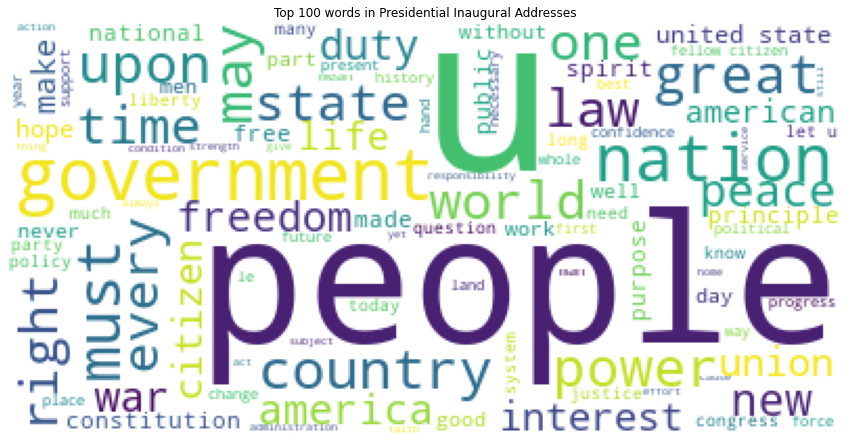

In [ ]:
from wordcloud import WordCloud as wc

fig,axs = plt.subplots(1,figsize=(15,15))
axs.imshow(wc(background_color='white',max_words=100).generate(''.join(raw_data_df.lemmatized_tok_txt_wo_stopwords.tolist())))
axs.axis('off')
axs.set_title('Top 100 words in Presidential Inaugural Addresses')

In [ ]:

processed_texts = raw_data_df['lemmatized_tok_txt_wo_stopwords'].apply(lambda x : x.split(' '))
words_dictionary = Dictionary(processed_texts)

# Filter out extremes to limit the number of features
words_dictionary.filter_extremes(no_below=3,
                          no_above=0.9,
                          keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [words_dictionary.doc2bow(text) for text in processed_texts]

# Create a list of the topic numbers we want to try in increasing order
topic_numbers = list(np.arange(5, 70 + 1, 5))

# Running the nmf model and to get the coherence score for each number of topics
coherence_scores = []

# word_dict = {};
usertime=[]
memory=[]

for nums in topic_numbers:
    tracemalloc.start()
    nmf = Nmf(
        corpus=corpus,
        num_topics=nums,
        id2word=words_dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    usage=resource.getrusage(resource.RUSAGE_SELF)
    usertime.append(usage[1])
    memory.append(tracemalloc.get_traced_memory()[0] )
    tracemalloc.stop()
    
    coherence_model = CoherenceModel(
            model=nmf,
            texts=processed_texts,
            dictionary=words_dictionary,
            coherence='c_v'
        )
        
    coherence_scores.append(round(coherence_model.get_coherence(), 5))
  
# Get the number of topics with the highest coherence score
coherence_scores_tup = list(zip(topic_numbers, coherence_scores))
best_topics_number = sorted(coherence_scores_tup, key=itemgetter(1), reverse=True)[0][0]


In [ ]:
import resource
def using(point=""):
    usage=resource.getrusage(resource.RUSAGE_THREAD)
    print(usage)
    return '''%s: usertime=%s systime=%s mem=%s mb
           '''%(point,usage[0],usage[1],
                usage[2]/1024.0 )

In [ ]:
import gc

gc.collect()

print(using("before"))
wrk = ["wasting mem"] * 1000000
print(using("after"))

resource.struct_rusage(ru_utime=370.526997, ru_stime=7.382706, ru_maxrss=471048, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=163384, ru_majflt=515, ru_nswap=0, ru_inblock=122944, ru_oublock=173552, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=59504, ru_nivcsw=78195)
before: usertime=370.526997 systime=7.382706 mem=460.0078125 mb
           
resource.struct_rusage(ru_utime=370.527878, ru_stime=7.383704, ru_maxrss=471048, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=163811, ru_majflt=515, ru_nswap=0, ru_inblock=122944, ru_oublock=173552, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=59504, ru_nivcsw=78195)
after: usertime=370.527878 systime=7.383704 mem=460.0078125 mb
           


[36.569104, 37.073896, 37.736941, 38.694364, 39.969954, 40.885097, 41.830468, 42.863895, 43.997392, 45.148724, 46.48091, 47.803633, 49.206089, 50.807712]
[430571, 538757, 838641, 1069502, 1347910, 1613100, 1860918, 2144627, 2397414, 2661944, 2946178, 3194168, 3460520, 3752608]


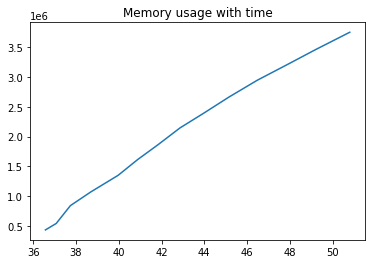

In [ ]:
from matplotlib import pyplot as plt1

plt1.title("Memory usage with time")
print(usertime)
print(memory)
# Plot values using x,y coordinates:
plt1.plot(usertime,memory)
plt1.show()

[(5, 0.32132), (10, 0.35144), (15, 0.35333), (20, 0.33156), (25, 0.34373), (30, 0.34559), (35, 0.34233), (40, 0.3413), (45, 0.33721), (50, 0.33861), (55, 0.33561), (60, 0.33406), (65, 0.33192), (70, 0.32627)]


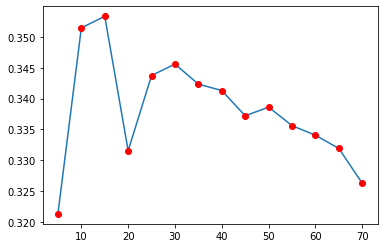


 The Best number of topics for maximum coherence score -  15


In [ ]:
print(coherence_scores_tup)
x_val = [x[0] for x in coherence_scores_tup]
y_val = [x[1] for x in coherence_scores_tup]

plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.show()

print("\n The Best number of topics for maximum coherence score - ",best_topics_number)